In [44]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [45]:
import os
print(os.listdir("/kaggle/input"))


['shl-intern-hiring-assessment-2025']


In [46]:
os.listdir("/kaggle/input/shl-intern-hiring-assessment-2025")


['dataset']

In [47]:
import os

for root, dirs, files in os.walk("/kaggle/input"):
    print("ROOT:", root)
    print("DIRS:", dirs)
    print("FILES:", files[:5])
    print("-"*50)

ROOT: /kaggle/input
DIRS: ['shl-intern-hiring-assessment-2025']
FILES: []
--------------------------------------------------
ROOT: /kaggle/input/shl-intern-hiring-assessment-2025
DIRS: ['dataset']
FILES: []
--------------------------------------------------
ROOT: /kaggle/input/shl-intern-hiring-assessment-2025/dataset
DIRS: ['audios', 'csvs']
FILES: []
--------------------------------------------------
ROOT: /kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios
DIRS: ['test', 'train']
FILES: []
--------------------------------------------------
ROOT: /kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/test
DIRS: []
FILES: ['audio_49.wav', 'audio_67_1.wav', 'audio_90.wav', 'audio_77.wav', 'audio_20_1.wav']
--------------------------------------------------
ROOT: /kaggle/input/shl-intern-hiring-assessment-2025/dataset/audios/train
DIRS: []
FILES: ['audio_49.wav', 'audio_77_2.wav', 'audio_90.wav', 'audio_77.wav', 'audio_66.wav']
----------------------------------------

In [48]:
BASE_PATH = "/kaggle/input/shl-intern-hiring-assessment-2025/dataset"

TRAIN_CSV = f"{BASE_PATH}/csvs/train.csv"
TEST_CSV  = f"{BASE_PATH}/csvs/test.csv"

TRAIN_AUDIO_DIR = f"{BASE_PATH}/audios/train"
TEST_AUDIO_DIR  = f"{BASE_PATH}/audios/test"

In [49]:
import os
import pandas as pd

print("Train CSV exists:", os.path.exists(TRAIN_CSV))
print("Test CSV exists:", os.path.exists(TEST_CSV))

print("Train audio sample:", os.listdir(TRAIN_AUDIO_DIR)[:5])
print("Test audio sample:", os.listdir(TEST_AUDIO_DIR)[:5])

train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)

print(train_df.head())

Train CSV exists: True
Test CSV exists: True
Train audio sample: ['audio_49.wav', 'audio_77_2.wav', 'audio_90.wav', 'audio_77.wav', 'audio_66.wav']
Test audio sample: ['audio_49.wav', 'audio_67_1.wav', 'audio_90.wav', 'audio_77.wav', 'audio_20_1.wav']
    filename  label
0  audio_173    3.0
1  audio_138    3.0
2  audio_127    2.0
3   audio_95    2.0
4   audio_73    3.5


In [50]:
train_df.columns

Index(['filename', 'label'], dtype='object')

In [51]:
import librosa
import numpy as np

def load_audio(filename, mode="train"):
    if mode == "train":
        path = f"{TRAIN_AUDIO_DIR}/{filename}"
    else:
        path = f"{TEST_AUDIO_DIR}/{filename}"
        
    y, sr = librosa.load(path, sr=16000)
    y, _ = librosa.effects.trim(y)
    y = librosa.util.normalize(y)
    return y, sr

In [52]:
import os
import librosa
import numpy as np

def load_audio(filename, mode="train"):
    if not filename.endswith(".wav"):
        filename = filename + ".wav"
        
    if mode == "train":
        path = os.path.join(TRAIN_AUDIO_DIR, filename)
    else:
        path = os.path.join(TEST_AUDIO_DIR, filename)
    
    signal, sr = librosa.load(path, sr=16000)
    signal, _ = librosa.effects.trim(signal)
    signal = librosa.util.normalize(signal)
    return signal, sr

In [53]:
from tqdm import tqdm

X = []
y = []

for _, row in tqdm(train_df.iterrows(), total=len(train_df)):
    X.append(extract_features(row["filename"], mode="train"))
    y.append(row["label"])

X = np.array(X)
y = np.array(y)

print("Feature matrix shape:", X.shape)

100%|██████████| 409/409 [02:46<00:00,  2.45it/s]

Feature matrix shape: (409, 34)


In [54]:
y, sr = load_audio(train_df.iloc[0]["filename"], mode="train")
print("Sample rate:", sr)
print("Duration (sec):", len(y) / sr)

Sample rate: 16000
Duration (sec): 59.84


In [55]:
print(X.shape, y.shape)

(409, 34) (957440,)


In [56]:
labels = train_df["label"].values
print("labels shape:", labels.shape)

labels shape: (409,)


In [64]:
print("X shape:", X.shape)

X shape: (409, 34)


In [63]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X,
    labels,
    test_size=0.2,
    random_state=42
)

print("Train:", X_train.shape, y_train.shape)
print("Val:", X_val.shape, y_val.shape)

Train: (327, 34) (327,)
Val: (82, 34) (82,)


In [62]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=300, n_jobs=-1, random_state=42)

In [66]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

# 1️⃣ Re-create train–validation split (safe reset)
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X,
    labels,
    test_size=0.2,
    random_state=42
)

# 2️⃣ Train model
model = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

# 3️⃣ Generate predictions
train_preds = model.predict(X_train)
val_preds   = model.predict(X_val)

# 4️⃣ Compute RMSE (manual, sklearn-version safe)
train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
val_rmse   = np.sqrt(mean_squared_error(y_val, val_preds))

print("Training RMSE:", train_rmse)
print("Validation RMSE:", val_rmse)

# 5️⃣ Pearson Correlation (Leaderboard metric)
corr, _ = pearsonr(y_val, val_preds)
print("Pearson Correlation:", corr)

Training RMSE: 0.27580779020719093
Validation RMSE: 0.70593330849547
Pearson Correlation: 0.4362412200983044


In [67]:
from scipy.stats import pearsonr

corr, _ = pearsonr(y_val, val_preds)
print("Pearson Correlation:", corr)

Pearson Correlation: 0.4362412200983044


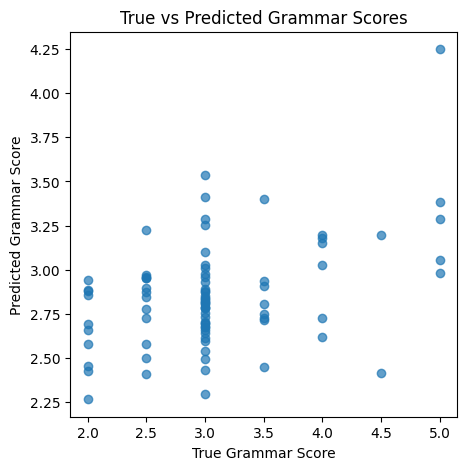

In [68]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.scatter(y_val, val_preds, alpha=0.7)
plt.xlabel("True Grammar Score")
plt.ylabel("Predicted Grammar Score")
plt.title("True vs Predicted Grammar Scores")
plt.show()

In [69]:
from sklearn.ensemble import RandomForestRegressor

final_model = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

final_model.fit(X, labels)

RandomForestRegressor(n_estimators=300, n_jobs=-1, random_state=42)

In [70]:
BASE_PATH = "/kaggle/input/shl-intern-hiring-assessment-2025/dataset"

TRAIN_CSV = f"{BASE_PATH}/csvs/train.csv"
TEST_CSV  = f"{BASE_PATH}/csvs/test.csv"

TRAIN_AUDIO_DIR = f"{BASE_PATH}/audios/train"
TEST_AUDIO_DIR  = f"{BASE_PATH}/audios/test"

In [71]:
import pandas as pd

test_df = pd.read_csv(TEST_CSV)
print("test_df shape:", test_df.shape)
test_df.head()

test_df shape: (197, 1)


,filename
0,audio_141
1,audio_114
2,audio_17
3,audio_76
4,audio_156


In [73]:
import os
import librosa
import numpy as np

def load_audio(filename, mode="train"):
    if not filename.endswith(".wav"):
        filename = filename + ".wav"
        
    if mode == "train":
        path = os.path.join(TRAIN_AUDIO_DIR, filename)
    else:
        path = os.path.join(TEST_AUDIO_DIR, filename)
    
    signal, sr = librosa.load(path, sr=16000)
    signal, _ = librosa.effects.trim(signal)
    signal = librosa.util.normalize(signal)
    return signal, sr


def extract_features(filename, mode="train"):
    signal, sr = load_audio(filename, mode)
    
    mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13)
    centroid = librosa.feature.spectral_centroid(y=signal, sr=sr)
    bandwidth = librosa.feature.spectral_bandwidth(y=signal, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(signal)
    rms = librosa.feature.rms(y=signal)
    
    features = np.hstack([
        mfcc.mean(axis=1),
        mfcc.std(axis=1),
        centroid.mean(), centroid.std(),
        bandwidth.mean(), bandwidth.std(),
        zcr.mean(), zcr.std(),
        rms.mean(), rms.std()
    ])
    
    return features

In [75]:
signal, sr = load_audio(test_df.iloc[0]["filename"], mode="test")
print("Sample rate:", sr)
print("Duration:", len(signal)/sr)

Sample rate: 16000
Duration: 41.72


In [80]:
import numpy as np

X_test = []
test_filenames = []

for _, row in test_df.iterrows():
    try:
        features = extract_features(row["filename"], mode="test")
        X_test.append(features)
        test_filenames.append(row["filename"])
    except Exception as e:
        print(f"Skipped {row['filename']} due to error: {e}")

X_test = np.array(X_test)

print("Total test files in CSV:", len(test_df))
print("Successfully extracted features:", X_test.shape[0])
print("Stored filenames:", len(test_filenames))

Total test files in CSV: 197
Successfully extracted features: 197
Stored filenames: 197


In [81]:
test_predictions = final_model.predict(X_test)

print("Predictions:", len(test_predictions))
print("Filenames:", len(test_filenames))

Predictions: 197
Filenames: 197


In [84]:
import pandas as pd

submission = pd.DataFrame({
    "filename": test_filenames,
    "label": test_predictions
})

submission.to_csv("submission.csv", index=False)
submission.head()

,filename,label
0,audio_141,2.561667
1,audio_114,2.865000
2,audio_17,3.258333
3,audio_76,3.551667
4,audio_156,3.046667


In [85]:
import os

os.listdir("/kaggle/working")

['submission.csv', '.virtual_documents']